# Load data

In [18]:
import numpy as np
import pandas as pd
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

from datetime import datetime
import time

In [19]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data preprocessing

In [20]:
def BatchGen(data, learnBatch, secLen, predLen, DType=torch.float64, targetIndex=0):
  batchReserved = secLen + learnBatch - 1
  batchCount = (data.size()[1] - predLen) // batchReserved
  X = torch.empty((batchCount, secLen, learnBatch, 1, 1), dtype=DType)
  Y = torch.empty((batchCount, learnBatch, 1, predLen), dtype=DType)

  for batch in range(batchCount):
    begin = batch * batchReserved
    for dot in range(secLen):
      X[batch][dot] = data[targetIndex][begin + dot:begin + dot + learnBatch].view((-1, 1, 1))

    for i in range(learnBatch):
      Y[batch][i][0] = data[targetIndex][begin + i:begin + i + predLen]

  return X, Y

def TestSample(data, secLen, DType=torch.float64, targetIndex=0):
  testLen = len(data[targetIndex]) - secLen
  result = torch.transpose(torch.tensor([data[targetIndex][i:i + secLen].tolist()\
          for i in range(testLen)], dtype=DType), 0, 1)
  return result.view((secLen, testLen, 1, 1))

def GetNormalizeConstants(data):
  normSub = np.min(data)
  normDiv = np.max(data - normSub)
  return normSub, normDiv

def MAPE(y, pred):
  return np.sum(np.abs(pred - y) / y) / len(y) * 100.0

In [21]:
PlotColors = ['b', 'g', 'r', 'cornflowerblue', 'c', 'm', 'y']

def PlotPredictions(y, pred, atr, MAPE):
  fig, ax = plt.subplots()
  fig.set_figwidth(12)
  fig.set_figheight(6)

  for i in range(atr['PredLen']):
    ax.plot(pred[i], label='прогноз ' + str(i + 1), color=PlotColors[i])
  ax.plot(y, label='Y', color='orange')

  ax.set_ylabel('цена, USD')
  ax.set_xlabel('время, часы')
  ax.legend(loc='best')

  print('MAPE ' + str(MAPE))
  print({'SecLen':atr['SecLen'], ' PredLen':atr['PredLen'], 'Epochs':atr['Epochs'],
         'LR':atr['LR'], 'M':atr['M'], 'target':TargetAttribute})

def PredMAPE(y, pred, predLen):
  return [MAPE(y, pred[i]) for i in range(predLen)]

In [22]:
fileName = '/content/drive/My Drive/Colab Notebooks/ML/data/GDAX.BTC-USD_160101_200528_h.csv'
data = pd.read_csv(fileName, sep=',')
data.rename(columns={'<DATE>':'date', '<TIME>':'time', '<OPEN>':'open',\
      '<HIGH>':'high', '<LOW>':'low', '<CLOSE>':'close', '<VOL>':'vol'}, inplace=True)
data

,date,time,open,high,low,close,vol
0,10116,10000,431.96,434.00,431.75,432.88,214
1,10116,20000,432.83,433.13,430.25,431.64,667
2,10116,30000,431.49,432.01,429.00,430.35,322
3,10116,40000,430.35,431.82,430.35,430.61,160
4,10116,50000,430.59,430.98,430.00,430.78,89
...,...,...,...,...,...,...,...
38081,280520,210000,9450.14,9477.13,9448.83,9470.01,490
38082,280520,220000,9470.01,9482.16,9430.01,9430.01,513
38083,280520,230000,9430.01,9483.00,9408.27,9453.99,488
38084,290520,0,9455.46,9462.68,9420.45,9446.57,360


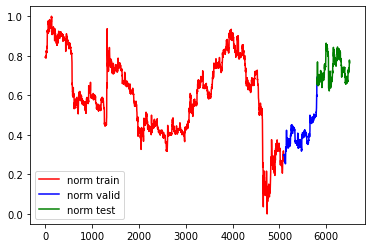

In [23]:
ReservedSecLen = 100
TrainLen = 5000 # 8000 # 6000
TestLen = 600 + ReservedSecLen
ValidLen = 600 + ReservedSecLen

TargetAttribute = 'high'
AttributesOrder = ['high', 'low', 'close', 'vol']
DataAttributes = {'high':0, 'low':1, 'close':2, 'vol':3}
TargetIndex = DataAttributes[TargetAttribute]

TrainBegin = len(data) - ReservedSecLen - TrainLen - TestLen - ValidLen
TestBegin = len(data) - TestLen - ValidLen
ValidBegin = len(data) - ValidLen

train = torch.transpose(torch.Tensor(data[AttributesOrder]\
                            [TrainBegin:TestBegin].to_numpy()).double(), 0, 1)
test = torch.transpose(torch.Tensor(data[AttributesOrder]\
                            [TestBegin:ValidBegin].to_numpy()).double(), 0, 1)
valid = torch.transpose(torch.Tensor(data[AttributesOrder]\
                            [ValidBegin:].to_numpy()).double(), 0, 1)

NormSub, NormDiv = [x for x in range(len(AttributesOrder))], [x for x in range(len(AttributesOrder))]
for i in range(len(AttributesOrder)):
  NormSub[i], NormDiv[i] = GetNormalizeConstants(data[TargetAttribute][TrainBegin:])
  train[i] = (train[i] - NormSub[i]) / NormDiv[i]
  test[i] = (test[i] - NormSub[i]) / NormDiv[i]
  valid[i] = (valid[i] - NormSub[i]) / NormDiv[i]

plt.plot([x for x in range(TrainLen + ReservedSecLen)], train[TargetIndex],
         label='norm train', color='r')
plt.plot([x + TrainLen + ReservedSecLen for x in range(TestLen)],\
         test[TargetIndex], label='norm valid', color='b')
plt.plot([x + TrainLen + ReservedSecLen + TestLen for x in range(ValidLen)],\
         valid[TargetIndex], label='norm test', color='g')
plt.legend(loc='best')
plt.show()

# Small LSTM

In [24]:
class SmallLSTM(nn.Module):
  def __init__(self, LR=0.02, m=0.65, SecLen=100, PredLen=4):
    super(SmallLSTM, self).__init__()

    self.secLen = SecLen
    self.predLen = PredLen

    self.lstm1 = nn.LSTM(
      input_size=1, hidden_size=220,
      num_layers=1, batch_first=True
    )
    self.linear1 = nn.Linear(220, 1)

    self.double()
    self.cuda()
    self.devCuda = torch.device('cuda')

    self.optimizer = torch.optim.SGD(self.parameters(), lr=LR, momentum=m)
    self.loss_func = nn.L1Loss()

  def run(self, x):
    state1 = None

    result = torch.empty((x.size()[1], 1, self.predLen),\
                dtype=torch.float64, device=self.devCuda)
    
    for i in range(self.secLen - 1):
      out1, state1 = self.lstm1(x[i], state1)
    
    out1 = x[self.secLen - 1]
    for i in range(self.predLen):
      out1, state1 = self.lstm1(out1, state1)
      out1 = self.linear1(out1)
      result[:, 0, i] = out1.view((-1))
    
    return result

  def forward(self, x):
    if x.device.type == 'cpu':
      return self.run(x.cuda(device=self.devCuda)).cpu()
    else:
      return self.run(x)

  def fit(self, X, Y, epochs = 10):
    batchCount = X.size()[0]
    batchSize = X.size()[1]
    dots = batchCount * batchSize
    losses = torch.empty(epochs * batchCount, dtype=torch.float32,
                        requires_grad=False, device=self.devCuda)
    for epoch in range(epochs):
      for batch in range(batchCount):
        loss = self.loss_func(self.forward(X[batch]), Y[batch])
        losses[epoch * dots + batch * batchSize:\
               epoch * dots + (batch + 1) * batchSize] = loss

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    return losses.detach().cpu()

# Fit and run

0:24:34.728205


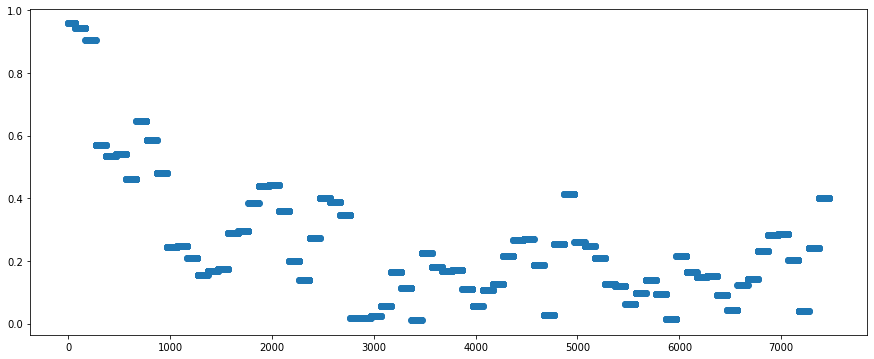

In [25]:
small = {'LearnBatch':100, 'SecLen':100, 'PredLen':4,
'Epochs':300, 'LR':0.013, 'M':0.25}

small['trainX'], small['trainY'] = BatchGen(train, small['LearnBatch'],\
                                        small['SecLen'], small['PredLen'])

small['net'] = SmallLSTM(LR=small['LR'], m=small['M'],\
                        SecLen=small['SecLen'], PredLen=small['PredLen'])
start_time = datetime.now()
small['losses'] = small['net'].fit(small['trainX'], small['trainY'],\
                                   epochs=small['Epochs'])

print(datetime.now() - start_time)
plt.figure(figsize=(15, 6))
skip = 30
plt.scatter(np.array([float(i) for i in range(len(small['losses'][skip:]))]),\
            small['losses'][skip:].numpy())

MAPE [1.1434813300296653, 1.1641948577726764, 1.1914897260891189, 1.2206867950772669]
{'SecLen': 100, ' PredLen': 4, 'Epochs': 300, 'LR': 0.013, 'M': 0.25, 'target': 'high'}


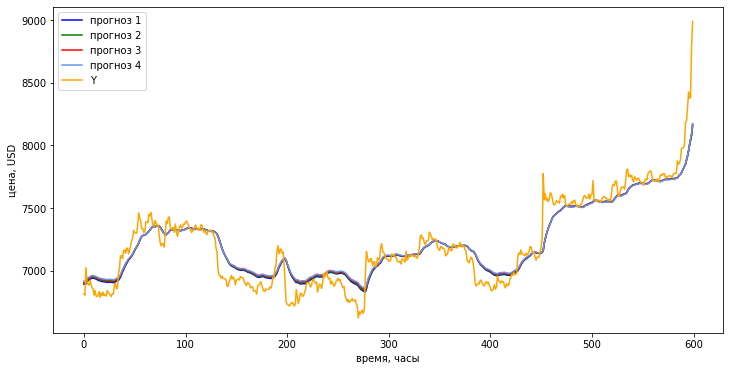

In [26]:
small['testX'] = TestSample(test, small['SecLen'])
small['validX'] = TestSample(valid, small['SecLen'])

testPred = torch.transpose(small['net'](TestSample(test, small['SecLen']))\
      .view((-1, small['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
testY = data[TargetAttribute][TestBegin + small['SecLen']:ValidBegin].to_numpy()
small['MAPETest'] = PredMAPE(testY, testPred, small['PredLen'])

PlotPredictions(testY, testPred, small, small['MAPETest'])

MAPE [2.174315188548539, 2.328480078331598, 2.5006819043735278, 2.6833774774141834]
{'SecLen': 100, ' PredLen': 4, 'Epochs': 300, 'LR': 0.013, 'M': 0.25, 'target': 'high'}


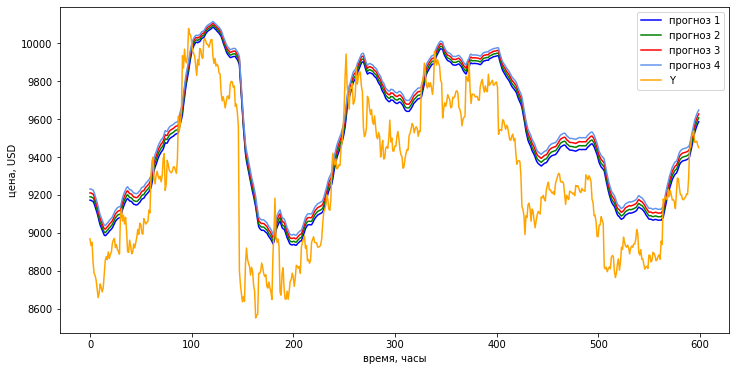

In [27]:
validPred = torch.transpose(small['net'](TestSample(valid, small['SecLen']))\
      .view((-1, small['PredLen'])), 0, 1).detach().numpy()\
      * NormDiv[TargetIndex] + NormSub[TargetIndex]
validY = data[TargetAttribute][small['SecLen'] + ValidBegin:].to_numpy()
small['MAPETest'] = PredMAPE(validY, validPred, small['PredLen'])

PlotPredictions(validY, validPred, small, small['MAPETest'])

# Save/Load

In [28]:
#path = '/content/drive/My Drive/Colab Notebooks/ML/dissertation5/LSTMSmallMax'
#torch.save(secondSmall, path)
#torch.save(small, path)

In [29]:
#path = '/content/drive/My Drive/Colab Notebooks/ML/dissertation5/LSTMSmallMin'
#loaded = torch.load(path)
#loaded['net'].eval()

#small = loaded
#SecondAttribute = 'low'
#SecondIndex = DataAttributes[SecondAttribute]

In [30]:
#testPred = torch.transpose(loaded['net'](TestSample(test, loaded['SecLen']))\
#      .view((-1, loaded['PredLen'])), 0, 1).detach().numpy()\
#      * NormDiv[TargetIndex] + NormSub[TargetIndex]
#testY = data[TargetAttribute][TestBegin + loaded['SecLen']:ValidBegin].to_numpy()
#loaded['MAPETest'] = PredMAPE(testY, testPred, loaded['PredLen'])

#PlotPredictions(testY, testPred, loaded, loaded['MAPETest'])